In [96]:
!pip install pinecone-client openai sentence-transformers tiktoken datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.9/266.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 13.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pinecone-client
    Found existing installation: pinecone-client 3.0.1
    Uninstalling pinecone-client-3.0.1:
      Successfully uninstalled pinecone-client-3.0.1
  Attempting uninstall: tiktoken
    Found existing installation: tiktoken 0.5.2
    Uninstalling tiktoken-0.5.2:
      Successfully uninstalled tiktoken-0.5.2
  Attempting uninstall: openai
    Found existing installation: openai 1.10.0
    Uninstalling openai-1.10.0:
      Successfully uninstalled openai-1.10.0
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.2
    Uninstalling sentence-transformers-2.2.2:
      Succes

In [1]:
from openai import OpenAI
from datetime import datetime
import hashlib
import re
import os
from sentence_transformers import CrossEncoder


from tqdm import tqdm
import numpy as np
from torch import nn

import logging
from pinecone import Pinecone, ServerlessSpec

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


# Getting Started with Semantic Search

In [4]:
pinecone_key = os.environ.get('PINECONE_API_KEY')
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

INDEX_NAME = 'semantic-search-health-idx'
NAMESPACE = 'default'
ENGINE = 'text-embedding-3-large'  # has size 3072

pc = Pinecone(
    api_key=pinecone_key
)

In [5]:
# helper functions to get lists of embeddings from the OpenAI API
def get_embeddings(texts, engine=ENGINE):
    response = client.embeddings.create(
        input=texts,
        model=engine
    )

    return [d.embedding for d in list(response.data)]

def get_embedding(text, engine=ENGINE):
    return get_embeddings([text], engine)[0]

len(get_embedding('hi')), len(get_embeddings(['hi', 'hello']))

(3072, 2)

In [6]:
if INDEX_NAME not in pc.list_indexes().names():
    print(f'Creating index {INDEX_NAME}')
    pc.create_index(
        name=INDEX_NAME,  # The name of the index
        dimension=3072,  # The dimensionality of the vectors for our OpenAI embedder
        metric='cosine',  # The similarity metric to use when searching the index
        spec=ServerlessSpec(
            cloud='aws',
            region='us-west-2'
        )
    )

# Store the index as a variable
index = pc.Index(name=INDEX_NAME)
index

In [7]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [11]:
def my_hash(s):
    # Return the MD5 hash of the input string as a hexadecimal string
    return hashlib.md5(s.encode()).hexdigest()

my_hash('I love to hash it')

'ae76cc4dfd345ecaeea9b8ba0d5c3437'

In [12]:
def prepare_for_pinecone(texts, engine=ENGINE):
    # Get the current UTC date and time
    now = datetime.utcnow()

    # Generate vector embeddings for each string in the input list, using the specified engine
    embeddings = get_embeddings(texts, engine=engine)

    # Create tuples of (hash, embedding, metadata) for each input string and its corresponding vector embedding
    # The my_hash() function is used to generate a unique hash for each string, and the datetime.utcnow() function is used to generate the current UTC date and time
    return [
        (
            my_hash(text),  # A unique ID for each string, generated using the my_hash() function
            embedding,  # The vector embedding of the string
            dict(text=text, date_uploaded=now)  # A dictionary of metadata, including the original text and the current UTC date and time
        )
        for text, embedding in zip(texts, embeddings)  # Iterate over each input string and its corresponding vector embedding
    ]


In [33]:
texts = ['hi']

In [34]:
_id, embedding, metadata = prepare_for_pinecone(texts)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  3072 
META: {'text': 'hi', 'date_uploaded': datetime.datetime(2024, 4, 3, 14, 55, 29, 838076)}


## Uploading Text to our DB

In [35]:
def upload_texts_to_pinecone(texts, namespace=NAMESPACE, batch_size=None, show_progress_bar=False):
    # Call the prepare_for_pinecone function to prepare the input texts for indexing
    total_upserted = 0
    if not batch_size:
        batch_size = len(texts)

    _range = range(0, len(texts), batch_size)
    for i in tqdm(_range) if show_progress_bar else _range:
        batch = texts[i: i + batch_size]
        prepared_texts = prepare_for_pinecone(batch)

        # Use the upsert() method of the index object to upload the prepared texts to Pinecone
        total_upserted += index.upsert(
            vectors=prepared_texts,
            namespace=namespace
        )['upserted_count']


    return total_upserted

# Call the upload_texts_to_pinecone() function with the input texts
upload_texts_to_pinecone(texts)


1

In [50]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'default': {'vector_count': 978}},
 'total_vector_count': 978}

In [37]:
texts

['hi']

In [38]:
def query_from_pinecone(query, top_k=3, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

query_from_pinecone('hello', top_k=1)

[]

In [19]:
import hashlib

def delete_texts_from_pinecone(texts, namespace=NAMESPACE):
    # Compute the hash (id) for each text
    hashes = [hashlib.md5(text.encode()).hexdigest() for text in texts]

    # The ids parameter is used to specify the list of IDs (hashes) to delete
    return index.delete(ids=hashes, namespace=namespace)

# delete our text
delete_texts_from_pinecone(texts)

# test that the index is empty
query_from_pinecone('hello')

[]

In [40]:
# Importing the tiktoken library
import tiktoken

# Initializing a tokenizer for the 'cl100k_base' model
# This tokenizer is designed to work with the 'ada-002' embedding model
tokenizer = tiktoken.get_encoding("cl100k_base")

# Using the tokenizer to encode the text 'hey there'
# The resulting output is a list of integers representing the encoded text
# This is the input format required for embedding using the 'ada-002' model
tokenizer.encode('hey there')


[36661, 1070]

# Chunking

In [41]:
# Function to split the text into chunks of a maximum number of tokens. Inspired by OpenAI
def overlapping_chunks(text, max_tokens = 500, overlapping_factor = 5):
    '''
    max_tokens: tokens we want per chunk
    overlapping_factor: number of sentences to start each chunk with that overlaps with the previous chunk
    '''

    # Split the text using punctuation
    sentences = re.split(r'[.?!]', text)

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks, tokens_so_far, chunk = [], 0, []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            if overlapping_factor > 0:
                chunk = chunk[-overlapping_factor:]
                tokens_so_far = sum([len(tokenizer.encode(c)) for c in chunk])
            else:
                chunk = []
                tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks

In [42]:
import PyPDF2

# Open the PDF file in read-binary mode
with open('../data/pds2.pdf', 'rb') as file:

    # Create a PDF reader object
    reader = PyPDF2.PdfReader(file)

    # Initialize an empty string to hold the text
    principles_of_ds = ''
    # Loop through each page in the PDF file
    for page in tqdm(reader.pages):
        text = page.extract_text()
        principles_of_ds += '\n\n' + text[text.find(' ]')+2:]

# Print the final string containing all the text from the PDF file
principles_of_ds = principles_of_ds.strip()

print(len(principles_of_ds))


100%|██████████████████████████████████████████████████████████████████████████████████| 428/428 [06:28<00:00,  1.10it/s]

575490


In [43]:
split = overlapping_chunks(principles_of_ds, overlapping_factor=0)
avg_length = sum([len(tokenizer.encode(t)) for t in split]) / len(split)
print(f'non-overlapping chunking approach has {len(split)} documents with average length {avg_length:.1f} tokens')

non-overlapping chunking approach has 286 documents with average length 474.1 tokens


In [44]:
split = overlapping_chunks(principles_of_ds)
avg_length = sum([len(tokenizer.encode(t)) for t in split]) / len(split)
print(f'overlapping chunking approach has {len(split)} documents with average length {avg_length:.1f} tokens')

overlapping chunking approach has 392 documents with average length 485.2 tokens


In [45]:
# Importing the Counter and re libraries
from collections import Counter
import re

# Find all occurrences of one or more spaces in 'principles_of_ds'
matches = re.findall(r'[\s]{1,}', principles_of_ds)

# The 10 most frequent spaces that occur in the document
most_common_spaces = Counter(matches).most_common(10)

# Print the most common spaces and their frequencies
print(most_common_spaces)


[(' ', 82259), ('\n', 9220), ('  ', 1592), ('\n\n', 333), ('\n   ', 250), ('\n\n\n', 82), ('\n    ', 73), ('\n ', 46), (' \n', 39), ('     ', 34)]


In [46]:
# Only keep documents of at least 100 characters split by a custom delimiter
split = list(filter(lambda x: len(x) > 50, principles_of_ds.split('\n\n')))

avg_length = sum([len(tokenizer.encode(t)) for t in split]) / len(split)
print(f'custom delimiter approach has {len(split)} documents with average length {avg_length:.1f} tokens')

custom delimiter approach has 426 documents with average length 316.3 tokens


In [47]:
embeddings = None
for s in tqdm(range(0, len(split), 100)):
    if embeddings is None:
        embeddings = np.array(get_embeddings(split[s:s+100], engine=ENGINE))
    else:
        embeddings = np.vstack([embeddings, np.array(get_embeddings(split[s:s+100], engine=ENGINE))])


100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


In [63]:
np.percentile(cosine_sim_matrix.flatten(), 50)

0.2974705542613624

In [64]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assume you have a list of text embeddings called `embeddings`
# First, compute the cosine similarity matrix between all pairs of embeddings
cosine_sim_matrix = cosine_similarity(embeddings)

# Instantiate the AgglomerativeClustering model
agg_clustering = AgglomerativeClustering(
    n_clusters=None,         # the algorithm will determine the optimal number of clusters based on the data
    
    # clusters will be formed until all pairwise distances between clusters are greater than given value
    distance_threshold=np.percentile(cosine_sim_matrix.flatten(), 50),
    
    affinity='precomputed',  # we are providing a precomputed distance matrix (1 - similarity matrix) as input
    linkage='complete'       # form clusters by iteratively merging the smallest clusters based on the maximum distance between their components
)

# Fit the model to the cosine distance matrix (1 - similarity matrix)
agg_clustering.fit(1 - cosine_sim_matrix)

# Get the cluster labels for each embedding
cluster_labels = agg_clustering.labels_

# Print the number of embeddings in each cluster
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f'Cluster {label}: {count} embeddings')


Cluster 0: 3 embeddings
Cluster 1: 2 embeddings
Cluster 2: 2 embeddings
Cluster 3: 2 embeddings
Cluster 4: 3 embeddings
Cluster 5: 2 embeddings
Cluster 6: 3 embeddings
Cluster 7: 2 embeddings
Cluster 8: 2 embeddings
Cluster 9: 3 embeddings
Cluster 10: 2 embeddings
Cluster 11: 2 embeddings
Cluster 12: 2 embeddings
Cluster 13: 2 embeddings
Cluster 14: 2 embeddings
Cluster 15: 2 embeddings
Cluster 16: 2 embeddings
Cluster 17: 3 embeddings
Cluster 18: 2 embeddings
Cluster 19: 2 embeddings
Cluster 20: 2 embeddings
Cluster 21: 2 embeddings
Cluster 22: 2 embeddings
Cluster 23: 3 embeddings
Cluster 24: 3 embeddings
Cluster 25: 2 embeddings
Cluster 26: 2 embeddings
Cluster 27: 2 embeddings
Cluster 28: 2 embeddings
Cluster 29: 2 embeddings
Cluster 30: 2 embeddings
Cluster 31: 2 embeddings
Cluster 32: 2 embeddings
Cluster 33: 3 embeddings
Cluster 34: 2 embeddings
Cluster 35: 2 embeddings
Cluster 36: 2 embeddings
Cluster 37: 2 embeddings
Cluster 38: 2 embeddings
Cluster 39: 2 embeddings
Cluster 40

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [65]:
pruned_documents = []
for _label, count in zip(unique_labels, counts):
    pruned_documents.append('\n\n'.join([text for text, label in zip(split, cluster_labels) if label == _label]))


avg_length = sum([len(tokenizer.encode(t)) for t in pruned_documents]) / len(pruned_documents)
print(f'Our pruning approach has {len(pruned_documents)} documents with average length {avg_length:.1f} tokens')

Our pruning approach has 292 documents with average length 461.6 tokens


In [66]:
print(pruned_documents[0])


So, we have way more ham messages than we do spam. Because this is a classification
problem, it will be very useful to know our null accuracy rate , which is the percentage
chance of predicting a single row correctly if we keep guessing the most common class,
ham:
df.label.value_counts() / df.shape[0]
ham     0.865937
spam    0.134063
So if we blindly guessed ham, we would be correct about 87% of the time, but we can do
better than that. If we have a set of classes, C, and features, xi, then we can use Bayes'
theorem to predict the probability that a single row belongs to class C, using the following
formula:
Let's look at this formula in a little more detail:
P(class C | {xi}) : The posterior probability is the probability that the row belongs
to class C  given the features {xi}.
P({xi} | class C) : This is the likelihood that we would observe these features given
that the row was in class C .
P(class C) : This is the prior probability. It is the probability that the data point
belon

In [67]:
upload_texts_to_pinecone(pruned_documents, batch_size=128)

292

In [71]:
query = 'How do z scores work?'

results_from_pinecone = query_from_pinecone(query, top_k=3)

for result_from_pinecone in results_from_pinecone:
    print(f"{result_from_pinecone['id']}\t{result_from_pinecone['score']:.2f}\t{result_from_pinecone['metadata']['text'][:50]}")


30282dd530d9a170ec50c8252d337b33	0.56	Let's begin by learning a very  important value  i
126c5edbf7271df6e2d9983cd740ba10	0.50	We get this chart:
We can see that we have negativ
7da124bb8c927e0c392cf75d4bfb2c76	0.41	
Basic Statistics
This chapter will focus on the s


In [72]:
result_from_pinecone

{'id': '7da124bb8c927e0c392cf75d4bfb2c76',
 'metadata': {'date_uploaded': '2024-04-03T15:07:13.510992',
              'text': '\n'
                      'Basic Statistics\n'
                      'This chapter will focus on the statistical knowledge '
                      'required by any aspiring data scientist.\n'
                      'We will explore ways of sampling and obtaining data '
                      'without being affected by bias and\n'
                      'then use measures of statistics to quantify and '
                      'visualize our data. Using the z-score and the\n'
                      'empirical rule, we will see how we can standardize data '
                      'for the purpose of both graphing\n'
                      'and interpretability.\n'
                      'In this chapter, we will look at the following topics:\n'
                      'How to obtain and sample data\n'
                      'The measures of center, variance, and relative '
 

In [73]:
delete_texts_from_pinecone(pruned_documents)

{}

In [74]:
index.describe_index_stats()  # no vectors inside

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

# Working with Open-Source Cross-Encoders

In [75]:
"""
This example computes the score between a query and all possible
sentences in a corpus using a Cross-Encoder for semantic textual similarity (STS).
It output then the most similar sentences for the given query.
"""
from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np
from torch import nn

# Pre-trained cross encoder


In [76]:
# remove debug and info logs
import logging
logging.basicConfig(level=logging.WARNING)

In [8]:
from datasets import load_dataset

dataset = load_dataset("xtreme", "MLQA.en.en")

dataset['train'] = dataset['test']

# just renaming out of habit, sorry
dataset['test'] = dataset['validation']
del dataset['validation']

dataset

DatasetDict({
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1148
    })
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11590
    })
})

In [9]:
dataset['train'][0], dataset['train'][1]

({'id': 'a4968ca8a18de16aa3859be760e43dbd3af3fce9',
  'title': 'Area 51',
  'context': 'In 1994, five unnamed civilian contractors and the widows of contractors Walter Kasza and Robert Frost sued the USAF and the United States Environmental Protection Agency. Their suit, in which they were represented by George Washington University law professor Jonathan Turley, alleged they had been present when large quantities of unknown chemicals had been burned in open pits and trenches at Groom. Biopsies taken from the complainants were analyzed by Rutgers University biochemists, who found high levels of dioxin, dibenzofuran, and trichloroethylene in their body fat. The complainants alleged they had sustained skin, liver, and respiratory injuries due to their work at Groom, and that this had contributed to the deaths of Frost and Kasza. The suit sought compensation for the injuries they had sustained, claiming the USAF had illegally handled toxic materials, and that the EPA had failed in its dut

In [21]:
unique_passages = list(set(dataset['test']['context']))
upload_texts_to_pinecone(unique_passages, batch_size=16)

978

In [22]:
len(unique_passages)  # only 978 unique passages

978

In [23]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'default': {'vector_count': 978}},
 'total_vector_count': 978}

In [24]:
# Pre-trained cross encoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', num_labels=1)

q_to_hash = {data['question']: my_hash(data['context']) for data in dataset['test']}

In [25]:
import logging

# Set the logging level to ERROR to suppress DEBUG and INFO logs
logging.getLogger().setLevel(logging.ERROR)


In [29]:
from copy import copy

def get_results_from_pinecone(query, top_k=3, re_rank_model=None, verbose=True, correct_hash=None):
    results_from_pinecone = query_from_pinecone(query, top_k=top_k)

    if verbose:
        print("Query:", query)

    final_results = []

    retrieved_correct_position, reranked_correct_position = None, None
    for idx, result_from_pinecone in enumerate(results_from_pinecone):
        if correct_hash and result_from_pinecone['id'] == correct_hash:
            retrieved_correct_position = idx

    if re_rank_model is not None:
        if verbose:
            print('Document ID (Hash)\t\tRetrieval Score\tCE Score\tText')

        sentence_combinations = [[query, result_from_pinecone['metadata']['text']] for result_from_pinecone in results_from_pinecone]

        # Compute the similarity scores for these combinations
        similarity_scores = re_rank_model.predict(sentence_combinations, activation_fct=nn.Sigmoid())

        # Sort the scores in decreasing order
        sim_scores_argsort = list(reversed(np.argsort(similarity_scores)))
        for rerank_idx, idx in enumerate(sim_scores_argsort):
            result_from_pinecone = results_from_pinecone[idx]
            if correct_hash and result_from_pinecone['id'] == correct_hash:
                reranked_correct_position = rerank_idx
            final_results.append({'score': similarity_scores[idx], 'id': result_from_pinecone['id'], 'metadata': result_from_pinecone['metadata']})
            if verbose:
                print(f"{result_from_pinecone['id']}\t{result_from_pinecone['score']:.2f}\t{similarity_scores[idx]:.6f}\t{result_from_pinecone['metadata']['text'][:50]}")
        return {'final_results': final_results, 'retrieved_correct_position': retrieved_correct_position, 'reranked_correct_position': reranked_correct_position, 'results_from_pinecone': results_from_pinecone}

    if verbose:
        print('Document ID (Hash)\t\tRetrieval Score\tText')
    for result_from_pinecone in results_from_pinecone:
        final_results.append(result_from_pinecone)
        if verbose:
            print(f"{result_from_pinecone['id']}\t{result_from_pinecone['score']:.2f}\t{result_from_pinecone['metadata']['text'][:50]}")

    return {'final_results': final_results, 'retrieved_correct_position': retrieved_correct_position, 'reranked_correct_position': reranked_correct_position}

In [30]:
unique_inputs = list(set(dataset['test']['question']))
len(unique_inputs)

1148

In [37]:
for query in unique_inputs[:5]:
    
    r = get_results_from_pinecone(
        query, top_k=10, re_rank_model=cross_encoder, correct_hash=q_to_hash[query],
        verbose=False
        )
    
    print(query)
    print('raw retrieved index of correct result', r['retrieved_correct_position'])
    print('reranked index of correct result',  r['reranked_correct_position'])
    print('---')

In what year did Scipione Riva-Rocci invent the sphygmomanometer
raw retrieved index of correct result 0
reranked index of correct result 0
---
When did Muntjacs begin appearing?
raw retrieved index of correct result 0
reranked index of correct result 0
---
Who aided Germany?
raw retrieved index of correct result 2
reranked index of correct result 0
---
What can negatively affect medical devices?
raw retrieved index of correct result 0
reranked index of correct result 0
---
what can websites mine?
raw retrieved index of correct result 0
reranked index of correct result 0
---


In [38]:
# Let's test the performance re-ranking against validation datapoints
# Note we could not use Pinecone here to speed things up
#  but it's also a good time to see the latency of the pipeline with Pinecone
test_sample = dataset['test']

In [ ]:
TOP_K=50

In [ ]:
logger.setLevel(logging.CRITICAL)

predictions = []

for question in tqdm(test_sample['question']):
    r = get_results_from_pinecone(
        question, top_k=TOP_K, re_rank_model=cross_encoder, correct_hash=q_to_hash[question],
        verbose=False
        )

    r['retrieved_correct_position'], r['reranked_correct_position']
    predictions.append(r)

In [ ]:
retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in predictions])/len(predictions)
re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in predictions])/len(predictions)

print(f'Accuracy without re-ranking: {retrieved_accuracy}')
print(f'Accuracy with re-ranking: {re_ranked_accuracy}')

Accuracy without re-ranking: 0.7543554006968641
Accuracy with re-ranking: 0.8327526132404182


In [ ]:
import pandas as pd

predictions_df = pd.DataFrame(predictions)
predictions_df.head()

,final_results,retrieved_correct_position,reranked_correct_position,results_from_pinecone
0,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '2f90090e21f19450887d5f3ff781e541', '..."
1,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '49201636ad4102735125e146c0dbafa4', '..."
2,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '80d92494d2b06f341842f1855d2938cf', '..."
3,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,2.0,"[{'id': 'e3fd54f33b021ea3cf88b438fefcada7', '..."
4,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '37ed40c20d4e1b9cc8d6cc27a4d0fff3', '..."


In [ ]:
predictions_df[['retrieved_correct_position', 'reranked_correct_position']].mean()  # lower is better

retrieved_correct_position    1.311052
reranked_correct_position     0.682709
dtype: float64

In [ ]:
# do recall @ 1, 3, 5, 10
for k in (1, 3, 5, 10, 25, 50):
    embedding_only_recall = predictions_df[predictions_df['retrieved_correct_position'] < k].shape[0]
    reranked_recall = predictions_df[predictions_df['reranked_correct_position'] < k].shape[0]
    print(k, embedding_only_recall, reranked_recall)

1 866 956
3 1009 1057
5 1048 1077
10 1072 1094
25 1108 1120
50 1122 1122


In [ ]:
predictions_df.shape

(1148, 4)

# Fine-tuning our cross-encoder re-ranker

In [ ]:
dataset['train'][0]

{'id': 'a4968ca8a18de16aa3859be760e43dbd3af3fce9',
 'title': 'Area 51',
 'context': 'In 1994, five unnamed civilian contractors and the widows of contractors Walter Kasza and Robert Frost sued the USAF and the United States Environmental Protection Agency. Their suit, in which they were represented by George Washington University law professor Jonathan Turley, alleged they had been present when large quantities of unknown chemicals had been burned in open pits and trenches at Groom. Biopsies taken from the complainants were analyzed by Rutgers University biochemists, who found high levels of dioxin, dibenzofuran, and trichloroethylene in their body fat. The complainants alleged they had sustained skin, liver, and respiratory injuries due to their work at Groom, and that this had contributed to the deaths of Frost and Kasza. The suit sought compensation for the injuries they had sustained, claiming the USAF had illegally handled toxic materials, and that the EPA had failed in its duty t

In [ ]:
from sentence_transformers import InputExample, losses, evaluation
from torch.utils.data import DataLoader
from random import shuffle

shuffled_training_passages = dataset['train']['question'].copy()
shuffle(shuffled_training_passages)

In [ ]:
unique_train_passages = list(set(dataset['train']['context']))
len(unique_train_passages), len(dataset['train']['context'])

(9916, 11590)

In [ ]:
from sentence_transformers import SentenceTransformer

bi_encoder = SentenceTransformer("sentence-transformers/msmarco-MiniLM-L-6-v3")

In [ ]:
embeddings = bi_encoder.encode(
    unique_train_passages,
    show_progress_bar=True,
    batch_size=16,
    normalize_embeddings=True
)

Batches:   0%|          | 0/620 [00:00<?, ?it/s]

In [ ]:
len(unique_train_passages), embeddings.shape

(9916, (9916, 384))

In [ ]:
# use sentence_transformers.util.semantic_search
from sentence_transformers.util import semantic_search

unique_train_passages = np.array(unique_train_passages)

# Function to find most similar document
def find_most_similar(text, embeddings, documents, k=3):
    query_embedding = bi_encoder.encode([text], show_progress_bar=False)
    similarities = semantic_search(query_embedding, embeddings, top_k=k)
    return [(documents[sim['corpus_id']], sim['score'], sim['corpus_id']) for sim in similarities[0]]

In [ ]:
# Example usage
input_text = unique_train_passages[0]
print(input_text)

find_most_similar(input_text, embeddings, unique_train_passages)

The ancient Egyptians engaged in trade with their foreign neighbors to obtain rare, exotic goods not found in Egypt. In the Predynastic Period, they established trade with Nubia to obtain gold and incense. They also established trade with Palestine, as evidenced by Palestinian-style oil jugs found in the burials of the First Dynasty pharaohs. An Egyptian colony stationed in southern Canaan dates to slightly before the First Dynasty. Narmer had Egyptian pottery produced in Canaan and exported back to Egypt.By the Second Dynasty at latest, ancient Egyptian trade with Byblos yielded a critical source of quality timber not found in Egypt. By the Fifth Dynasty, trade with Punt provided gold, aromatic resins, ebony, ivory, and wild animals such as monkeys and baboons. Egypt relied on trade with Anatolia for essential quantities of tin as well as supplementary supplies of copper, both metals being necessary for the manufacture of bronze. The ancient Egyptians prized the blue stone lapis lazul

[("The ancient Egyptians engaged in trade with their foreign neighbors to obtain rare, exotic goods not found in Egypt. In the Predynastic Period, they established trade with Nubia to obtain gold and incense. They also established trade with Palestine, as evidenced by Palestinian-style oil jugs found in the burials of the First Dynasty pharaohs. An Egyptian colony stationed in southern Canaan dates to slightly before the First Dynasty. Narmer had Egyptian pottery produced in Canaan and exported back to Egypt.By the Second Dynasty at latest, ancient Egyptian trade with Byblos yielded a critical source of quality timber not found in Egypt. By the Fifth Dynasty, trade with Punt provided gold, aromatic resins, ebony, ivory, and wild animals such as monkeys and baboons. Egypt relied on trade with Anatolia for essential quantities of tin as well as supplementary supplies of copper, both metals being necessary for the manufacture of bronze. The ancient Egyptians prized the blue stone lapis la

In [ ]:
# add some negative examples
train_samples = []

for train_example in tqdm(dataset['train']):
    for i, (passage, score, corpus_idx) in enumerate(find_most_similar(train_example['question'], embeddings, unique_train_passages)):
        train_samples.append(
            InputExample(
                texts=[train_example['question'], passage], label=1 if i == 0 else 0
            )
        )

shuffle(train_samples)


100%|██████████| 11590/11590 [01:54<00:00, 100.86it/s]


In [ ]:
len(train_samples)

34770

In [ ]:
train_samples[0].__dict__

{'guid': '',
 'texts': ['How was Mike Leander also known as?',
  "Günter Theodor Netzer (born 14 September 1944 in Mönchengladbach) is a former German football player and team general manager currently working in the media business. He achieved great success in Germany with Borussia Mönchengladbach in the early 1970s, and, after moving to Spain in 1973, with Real Madrid. He played as an attacking midfielder, and is considered one of the greatest passers in the game's history. He was voted Footballer of the Year in Germany twice, in 1972 and 1973. He was the general manager for Hamburger SV during much of the team's golden period from the late 1970s through the early 1980s, when the club won three league titles and the 1983 European Cup."],
 'label': 0}

In [ ]:
train_samples[1].__dict__

{'guid': '',
 'texts': ['When did US troops finally leave Uzbekistan?',
  "In 1918, Japan continued to extend its influence and privileges in China via the Nishihara Loans. Following the Bolshevik Revolution in Russia, Japan and the United States sent forces to Siberia in 1918 to bolster the armies of the White movement leader Admiral Alexander Kolchak against the Bolshevik Red Army. In this Siberian Intervention, the Imperial Japanese Army initially planned to send more than 70,000 troops to occupy Siberia as far west as Lake Baikal. The plan was scaled back considerably due to opposition from the United States.Toward the end of the war, Japan increasingly filled orders for needed war material for its European allies. The wartime boom helped to diversify the country's industry, increase its exports, and transform Japan from a debtor to a creditor nation for the first time. Exports quadrupled from 1913 to 1918. The massive capital influx into Japan and the subsequent industrial boom le

In [ ]:
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator, CEBinaryClassificationEvaluator
import math
import torch
from random import sample

logger.setLevel(logging.DEBUG)  # just to get some logs

num_epochs = 1

model_save_path = './fine_tuned_ir_cross_encoder'

train_dataloader = DataLoader(train_samples[:int(len(train_samples)*.8)], shuffle=True, batch_size=16)

# An evaluator for training performance
evaluator = CECorrelationEvaluator.from_input_examples(train_samples[int(len(train_samples)*.8):], name='test')

# Rule of thumb for warmup steps
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up
print(f"Warmup-steps: {warmup_steps}")

Warmup-steps: 174


In [ ]:
for t in train_samples:
    if t.label == 1:
        print(t.__dict__, cross_encoder.predict(t.texts, activation_fct=nn.Sigmoid()))
        break
for t in train_samples:
    if t.label == 0:
        print(t.__dict__, cross_encoder.predict(t.texts, activation_fct=nn.Sigmoid()))
        break

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'guid': '', 'texts': ['What can be inferred about Zionism?', 'Determines that Zionism is a form of racism and racial discrimination.'], 'label': 1} 0.9391304


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'guid': '', 'texts': ['How was Mike Leander also known as?', "Günter Theodor Netzer (born 14 September 1944 in Mönchengladbach) is a former German football player and team general manager currently working in the media business. He achieved great success in Germany with Borussia Mönchengladbach in the early 1970s, and, after moving to Spain in 1973, with Real Madrid. He played as an attacking midfielder, and is considered one of the greatest passers in the game's history. He was voted Footballer of the Year in Germany twice, in 1972 and 1973. He was the general manager for Hamburger SV during much of the team's golden period from the late 1970s through the early 1980s, when the club won three league titles and the 1983 European Cup."], 'label': 0} 0.00016999716


In [ ]:
evaluator(cross_encoder)

0.3844874561927453

In [ ]:
# Train the model
from sentence_transformers import InputExample, losses, evaluation

# you may turn on debug for more logs here e.g. logger.setLevel(logging.DEBUG)
cross_encoder.fit(
    train_dataloader=train_dataloader,
    loss_fct=nn.BCEWithLogitsLoss(),  # this is the default loss if num_labels is 1 otherwise CrossEntropyLoss
    evaluator=evaluator,
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
    use_amp=True
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1739 [00:00<?, ?it/s]

In [ ]:
evaluator(cross_encoder)

0.42047041059290036

In [ ]:
finetuned = CrossEncoder(model_save_path)

print(finetuned.predict(['hello', 'hi'], activation_fct=nn.Sigmoid()))
print(finetuned.predict(['hello', 'hi'], activation_fct=nn.Identity()))

0.9973792
5.941634


In [ ]:
logger.setLevel(logging.CRITICAL)

ft_predictions = []

for question in tqdm(test_sample['question']):
    r = get_results_from_pinecone(
        question, top_k=TOP_K, re_rank_model=finetuned, correct_hash=q_to_hash[question],
        verbose=False
        )

    r['retrieved_correct_position'], r['reranked_correct_position']
    ft_predictions.append(r)
    if len(ft_predictions) % 100 == 0:
        retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)
        re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)

        print(f'Accuracy without re-ranking: {retrieved_accuracy}')
        print(f'Accuracy with re-ranking: {re_ranked_accuracy}')


  9%|▊         | 100/1148 [02:38<27:50,  1.59s/it]

Accuracy without re-ranking: 0.78
Accuracy with re-ranking: 0.84


 17%|█▋        | 200/1148 [05:18<26:10,  1.66s/it]

Accuracy without re-ranking: 0.765
Accuracy with re-ranking: 0.84


 26%|██▌       | 300/1148 [07:57<22:00,  1.56s/it]

Accuracy without re-ranking: 0.7666666666666667
Accuracy with re-ranking: 0.8266666666666667


 35%|███▍      | 400/1148 [10:37<19:44,  1.58s/it]

Accuracy without re-ranking: 0.7625
Accuracy with re-ranking: 0.84


 44%|████▎     | 500/1148 [13:17<17:16,  1.60s/it]

Accuracy without re-ranking: 0.764
Accuracy with re-ranking: 0.85


 52%|█████▏    | 600/1148 [16:00<14:35,  1.60s/it]

Accuracy without re-ranking: 0.7683333333333333
Accuracy with re-ranking: 0.8566666666666667


 61%|██████    | 700/1148 [18:40<12:28,  1.67s/it]

Accuracy without re-ranking: 0.7471428571428571
Accuracy with re-ranking: 0.8428571428571429


 70%|██████▉   | 800/1148 [21:21<09:13,  1.59s/it]

Accuracy without re-ranking: 0.74875
Accuracy with re-ranking: 0.835


 78%|███████▊  | 900/1148 [25:36<06:43,  1.63s/it]

Accuracy without re-ranking: 0.7388888888888889
Accuracy with re-ranking: 0.8333333333333334


 87%|████████▋ | 1000/1148 [28:16<04:00,  1.62s/it]

Accuracy without re-ranking: 0.741
Accuracy with re-ranking: 0.835


 96%|█████████▌| 1100/1148 [30:57<01:16,  1.60s/it]

Accuracy without re-ranking: 0.7509090909090909
Accuracy with re-ranking: 0.8436363636363636


100%|██████████| 1148/1148 [32:14<00:00,  1.68s/it]


In [ ]:
retrieved_accuracy = sum([_['retrieved_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)
re_ranked_accuracy = sum([_['reranked_correct_position'] == 0 for _ in ft_predictions])/len(ft_predictions)

print(f'Accuracy without re-ranking: {retrieved_accuracy}')
print(f'Accuracy with re-ranking: {re_ranked_accuracy}')

Accuracy without re-ranking: 0.7543554006968641
Accuracy with re-ranking: 0.8493031358885017


In [ ]:
# Re-ranking got slightly better after 1 epoch

In [ ]:
ft_predictions_df = pd.DataFrame(ft_predictions)
ft_predictions_df.head()

,final_results,retrieved_correct_position,reranked_correct_position,results_from_pinecone
0,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '2f90090e21f19450887d5f3ff781e541', '..."
1,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '49201636ad4102735125e146c0dbafa4', '..."
2,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '80d92494d2b06f341842f1855d2938cf', '..."
3,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': 'e3fd54f33b021ea3cf88b438fefcada7', '..."
4,"{'final_results': [{'score': 0.8746502, 'id': ...",0.0,0.0,"[{'id': '37ed40c20d4e1b9cc8d6cc27a4d0fff3', '..."


In [ ]:
ft_predictions_df[['retrieved_correct_position', 'reranked_correct_position']].isnull().sum()

retrieved_correct_position    26
reranked_correct_position     26
dtype: int64

In [ ]:
ft_predictions_df[['retrieved_correct_position', 'reranked_correct_position']].mean()

retrieved_correct_position    1.310160
reranked_correct_position     0.644385
dtype: float64

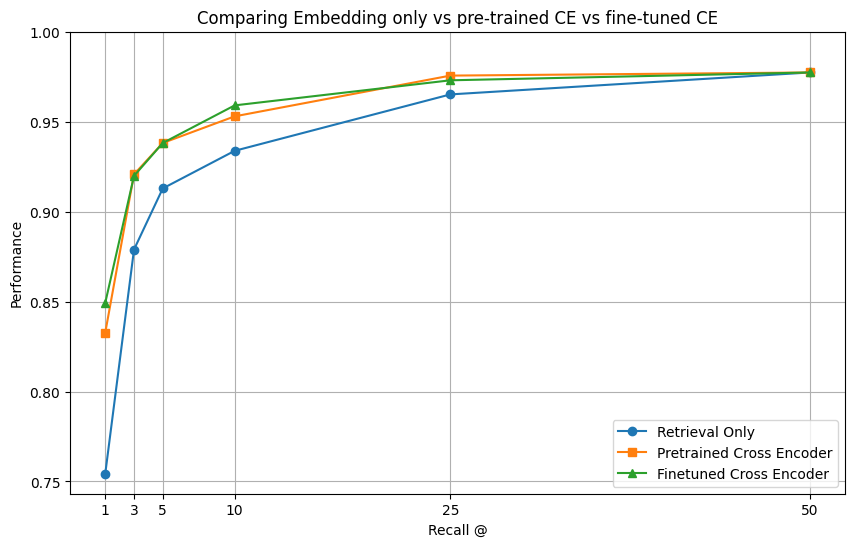

In [ ]:
# do recall @ 1, 3, 5, 10
for k in (1, 3, 5, 10, 25, 50):
    embedding_only_recall = ft_predictions_df[ft_predictions_df['retrieved_correct_position'] < k].shape[0]
    reranked_recall = ft_predictions_df[ft_predictions_df['reranked_correct_position'] < k].shape[0]
    print(k, embedding_only_recall, reranked_recall)

1 866 975
3 1009 1056
5 1048 1077
10 1072 1101
25 1108 1117
50 1122 1122


In [ ]:
ft_predictions_df.shape

(1148, 4)

# OPEN SOURCE ALTERNATIVE TO EMBEDDING

In [ ]:
docs = ["Around 9 Million people live in London", "London is known for its financial district"]
bi_encoder = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
doc_emb = bi_encoder.encode(docs, batch_size=32, show_progress_bar=True)

doc_emb.shape#  == ('2, 768')


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(2, 768)

In [ ]:
#Encode query and documents
docs = dataset['test']['context']
doc_emb = bi_encoder.encode(docs, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
from random import sample

query = sample(dataset['test']['question'], 1)[0]
print(query)
final_results = get_results_from_pinecone(query, top_k=3, re_rank_model=finetuned)


Where are some destinations flights from Paris Orly operate to?
Query: Where are some destinations flights from Paris Orly operate to?
Document ID (Hash)		Retrieval Score	CE Score	Text
2cefacc9828ba29e819c9a69e0b7b392	0.69	0.991276	Paris Orly Airport (French: Aéroport de Paris-Orly
bcea700839a1cefc7fbe752fcfbee880	0.24	0.111188	Iran Air Flight 277 was a passenger flight which c
20d2ff7276da85340534dabf110da251	0.24	0.096094	After the Treaty of Paris in 1763, which deprived 


In [ ]:
print(query)
find_most_similar(query, doc_emb, docs)

Where are some destinations flights from Paris Orly operate to?


[('Paris Orly Airport (French: Aéroport de Paris-Orly), commonly referred to as Orly (IATA: ORY, ICAO: LFPO), is an international airport located partially in Orly and partially in Villeneuve-le-Roi, 7 NM (13 km; 8.1 mi) south of Paris, France. It serves as a secondary hub for domestic and overseas territories flights of Air France and as the homebase for Transavia France.  Flights operate to destinations in Europe, the Middle East, Africa, the Caribbean, North America, East Asia and Southeast Asia. Prior to the opening of Charles de Gaulle Airport in March 1974, Orly was the main airport of Paris. Even with the shift of most international traffic to Charles de Gaulle Airport, Orly remains the busiest French airport for domestic traffic and the second busiest French airport overall in passenger traffic, with 33,120,685 passengers in 2018. The airport is operated by Groupe ADP under the brand Paris Aéroport. Since February 2018, the CEO of the airport has been Régis Lacote.',
  0.646585

In [ ]:
def eval_ranking_open_source(query, top_k=3, re_rank_model=None):
    ans = {'retrieved_correct_position': None}
    correct_hash = q_to_hash[query]
    results = find_most_similar(query, doc_emb, docs, k=top_k)
    for idx, (passage, score, doc_idx) in enumerate(results):
        if correct_hash == my_hash(passage):
            ans['retrieved_correct_position'] =  idx
    if re_rank_model is not None:
        ans['reranked_correct_position'] = None
        sentence_combinations = [(query, r[0]) for r in results]

        # Compute the similarity scores for these combinations
        similarity_scores = re_rank_model.predict(sentence_combinations, activation_fct=nn.Sigmoid())

        # Sort the scores in decreasing order
        sim_scores_argsort = list(reversed(np.argsort(similarity_scores)))
        for i, idx in enumerate(sim_scores_argsort):
            r = results[idx]
            if correct_hash and my_hash(r[0]) == correct_hash:
                ans['reranked_correct_position'] = i

    return ans

In [ ]:
eval_ranking_open_source(query, top_k=TOP_K, re_rank_model=finetuned)

{'retrieved_correct_position': 0, 'reranked_correct_position': 0}

In [ ]:
logger.setLevel(logging.CRITICAL)
os_predictions = []

for i, question in tqdm(enumerate(test_sample), total=len(test_sample)):
    os_predictions.append(eval_ranking_open_source(question['question'], top_k=TOP_K, re_rank_model=finetuned))

os_predictions_df = pd.DataFrame(os_predictions)
os_predictions_df.head()

100%|██████████| 1148/1148 [13:31<00:00,  1.42it/s]


,retrieved_correct_position,reranked_correct_position
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.0,0.0


In [ ]:
raw_accuracy = sum([p['retrieved_correct_position'] == 0 for p in os_predictions])/len(os_predictions)
reranked_accuracy = sum([p['reranked_correct_position'] == 0 for p in os_predictions])/len(os_predictions)

print(f'Accuracy without re-ranking: {raw_accuracy}')
print(f'Accuracy with re-ranking: {reranked_accuracy}')


Accuracy without re-ranking: 0.5017421602787456
Accuracy with re-ranking: 0.6193379790940766


In [ ]:
# do recall @ 1, 3, 5, 10
OPEN_SOURCE_RETRIEVAL = []
OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE = []
for k in (1, 3, 5, 10, 25, 50):
    embedding_only_recall = os_predictions_df[os_predictions_df['retrieved_correct_position'] < k].shape[0]
    reranked_recall = os_predictions_df[os_predictions_df['reranked_correct_position'] < k].shape[0]
    print(k, embedding_only_recall, reranked_recall)
    OPEN_SOURCE_RETRIEVAL.append(embedding_only_recall / os_predictions_df.shape[0])
    OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE.append(reranked_recall / os_predictions_df.shape[0])

1 576 711
3 887 1006
5 948 1055
10 1008 1087
25 1073 1103
50 1107 1107


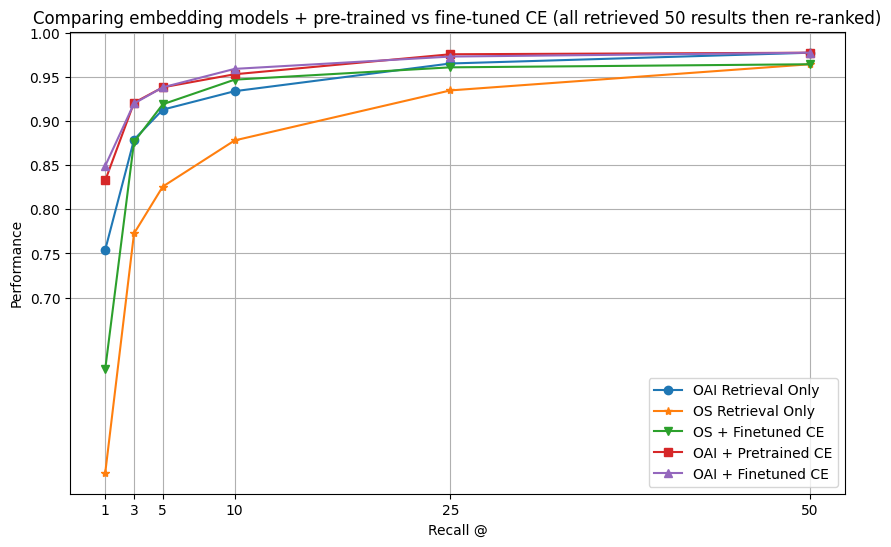

In [ ]:
import matplotlib.pyplot as plt

X = [1, 3, 5, 10, 25, 50]

OPENAI_RETRIEVAL = [866 / predictions_df.shape[0], 1009/ predictions_df.shape[0], 1048/ predictions_df.shape[0], 1072/ predictions_df.shape[0], 1108/ predictions_df.shape[0], 1122/ predictions_df.shape[0]]
# OPEN_SOURCE_RETRIEVAL = [663 / predictions_df.shape[0], 795/ predictions_df.shape[0], 838/ predictions_df.shape[0], 891/ predictions_df.shape[0], 966/ predictions_df.shape[0], 1004/ predictions_df.shape[0]]
OLD_CROSS_ENCODER = [956 / predictions_df.shape[0], 1057/ predictions_df.shape[0], 1077/ predictions_df.shape[0], 1094/ predictions_df.shape[0], 1120/ predictions_df.shape[0], 1122/ predictions_df.shape[0]]
NEW_CROSS_ENCODER = [975 / predictions_df.shape[0], 1056/ predictions_df.shape[0], 1077/ predictions_df.shape[0], 1101/ predictions_df.shape[0], 1117/ predictions_df.shape[0], 1122/ predictions_df.shape[0]]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(X, OPENAI_RETRIEVAL, label='OAI Retrieval Only', marker='o')
plt.plot(X, OPEN_SOURCE_RETRIEVAL, label='OS Retrieval Only', marker='*')
plt.plot(X, OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE, label='OS + Finetuned CE', marker='v')
plt.plot(X, OLD_CROSS_ENCODER, label='OAI + Pretrained CE', marker='s')
plt.plot(X, NEW_CROSS_ENCODER, label='OAI + Finetuned CE', marker='^')

# Adding titles and labels
plt.title('Comparing embedding models + pre-trained vs fine-tuned CE (all retrieved 50 results then re-ranked)')
plt.xlabel('Recall @')
plt.ylabel('Performance')
plt.xticks(X)
plt.yticks([i/100 for i in range(70, 101, 5)])  # Adjusting y-ticks to start from 0.75

# Adding legend
plt.legend()

# Show the plot
plt.grid(True)
# plt.show()

plt.savefig('recall_at_k.png', dpi=1000)

In [ ]:
# show results as a table

results_df = pd.DataFrame({'RECALL @': [1, 3, 5, 10, 25, 50], 'OS_Retrieval_Only': OPEN_SOURCE_RETRIEVAL, 'OS_Retrieval_Plus_Finetuned_CE': OPEN_SOURCE_RETRIEVAL_PLUS_FT_CE   , 'OAI_Retrieval_Only': OPENAI_RETRIEVAL    , 'OAI_Retrieval_Plus_Pretrained_CE': OLD_CROSS_ENCODER, 'OAI_Retrieval_Plus_Finetuned_CE': NEW_CROSS_ENCODER})
results_df

,RECALL @,OS_Retrieval_Only,OS_Retrieval_Plus_Finetuned_CE,OAI_Retrieval_Only,OAI_Retrieval_Plus_Pretrained_CE,OAI_Retrieval_Plus_Finetuned_CE
0,1,0.501742,0.619338,0.754355,0.832753,0.849303
1,3,0.772648,0.876307,0.878920,0.920732,0.919861
2,5,0.825784,0.918990,0.912892,0.938153,0.938153
3,10,0.878049,0.946864,0.933798,0.952962,0.959059
4,25,0.934669,0.960801,0.965157,0.975610,0.972997
5,50,0.964286,0.964286,0.977352,0.977352,0.977352


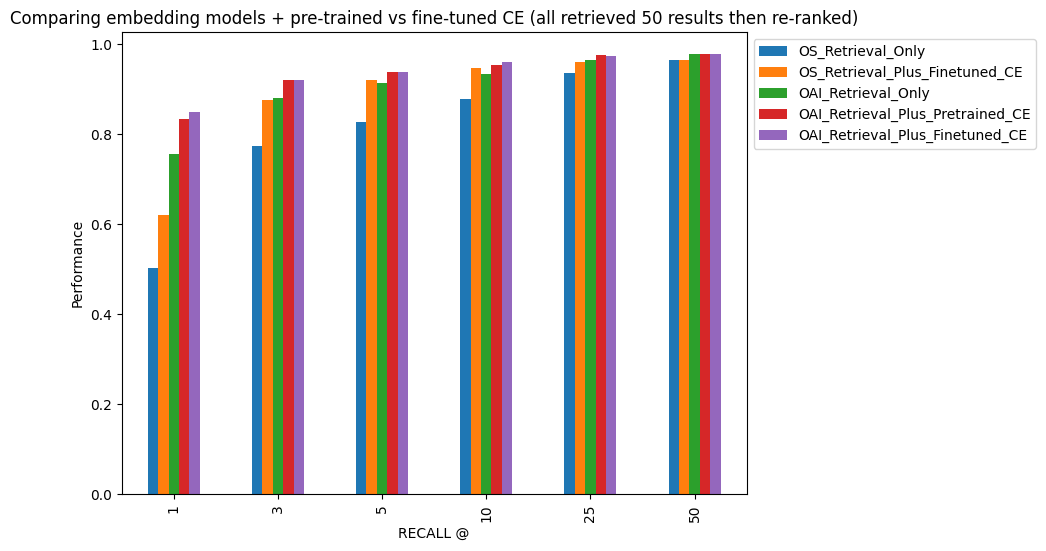

In [ ]:
# Assuming 'results_df' is your DataFrame
# Set 'RECALL @' as the index if it's intended to be used for x-axis labels
results_df.set_index('RECALL @', inplace=True)

# Plot the bar chart
ax = results_df.plot.bar(
    xlabel='RECALL @',
    ylabel='Performance',
    title='Comparing embedding models + pre-trained vs fine-tuned CE (all retrieved 50 results then re-ranked)',
    figsize=(10, 6)
)

# Move the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust subplot parameters to fit the legend outside of the plot
plt.subplots_adjust(right=0.75)

plt.savefig('recall_at_k_bar.png', dpi=1000)


# Using a deployed open source embedder (~$45 a month)

In [44]:
HF_TOKEN = userdata.get('HF_TOKEN')

In [51]:
import requests

API_URL = "https://rnlg7ggtdkep4h0i.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Authorization": f"Bearer {HF_TOKEN}",
	"Content-Type": "application/json" 
}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

output = query({
	"inputs": ["1", '2'],
})

In [52]:
len(output['embeddings'])

2

In [53]:
len(output['embeddings'][0])

768

In [54]:
output['embeddings'][0][:5]

[0.012244473211467266,
 -0.009157375432550907,
 0.004602040629833937,
 -0.024496469646692276,
 -0.004610566888004541]